# Computing Trends

#### Overview
In this notebook, we will start looking at ways to analyze ocean model data. As in previous lessons, we will use output from the ECCO Ocean State Estimate (Version 4).

#### Import Modules
First, import the modules required to access data from netCDF files and create plots:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm

After the modules are loaded in, establish a path to your data directory for this class:

In [2]:
# Define a path to a data folder
data_folder = 'C:\\Users\\tandre\\Desktop\\Spring 2025\\cs185c\\data'

## From visualizing to analyzing
In the previous notebooks, we've been focused on visualizing model output - first in space and then in time with timeseries and movies. But in all of this visualization, we have not done any real computation of change. Here, we'll start to look at ways to *quantify* change, starting with investigating trends.

### Example: Change in Northern Hemisphere Sea Ice
In the movie above, we've investigated changes in sea ice in the Arctic ocean. Below, we'll compute how the area of the sea ice has changed in time.


In looking at the units of sea ice above, it's clear that we need to multiply each grid cell by it's area since each cell gives the fraction of each cell covered by sea ice. Conceptually, it's easy to do - just multiply the fraction by the cell area. But what's the cell area? This is a little trickier since our data is given in longitude-latitude coordinates. Further, the area of cells at the equator are larger than those at the poles. We can check this out in a simple plot of the globe with grid lines:

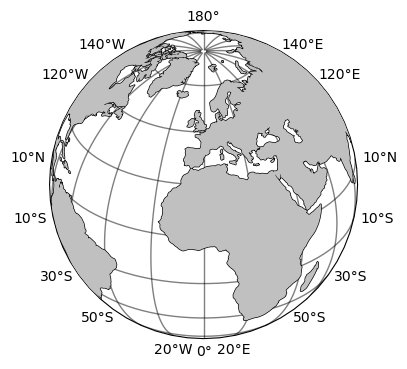

In [3]:
import matplotlib.ticker as mticker

# make a figure object with projection
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude = 30))

# add coastlines
plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
plt.gca().coastlines()

# add grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.5, linestyle='-')
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20))
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,20))
# format the axes
plt.show()

### Computing areas
If we assume the Earth is a perfect sphere with radius $R=$6,371 km, it's fairly straight-forward to compute the area of each cell if we think of each cell as taking up a given proportion of the sphere. On one hand, the area of a vertical latitude band between $\phi_1$ and $\phi_0$ has area

$$
A_{\text{Longitude Band}} = A_{Earth} \left(\frac{\phi_1 - \phi_0}{2\pi}\right)
$$

Further, a little trigonometry shows the the area of a portion of the sphere between the equator and a given latitude ($\theta$) is scaled by the *sin* of the latitude. Thus, in a given latitude band between $\theta_1$ and $\theta_0$, the fractional area is  

$$
A_{\text{Latitude Band}} = A_{Earth}\left(\frac{\sin (\theta_1) - \sin (\theta_0)}{2}\right)
$$

Putting these pieces together, we can compute the surface area of a given area of a sphere as 

$$
A_{patch} = R^2 (\phi_1 - \phi_0) (\sin (\theta_1) - \sin (\theta_0)) 
$$


In [8]:
# define the lon and lat bounds
lon_step = 0.5
lat_step = 0.5
lon_bounds = np.arange(-180, 180.01, lon_step)
lat_bounds = np.arange(-90, 90.01, lon_step)

# convert to radians
lon_bounds_rad = np.deg2rad(lon_bounds)
lat_bounds_rad = np.deg2rad(lat_bounds)

# make an array to store the area in each cell
R = 6371000
Area = np.zeros((360, 720))
for i in range(len(lon_bounds)-1):
    for j in range(len(lat_bounds)-1):
        # enter area formula here
        Area[j,i] = R**2 *(lon_bounds_rad[i+1] - lon_bounds_rad[i]) * \
                        (np.sin(lat_bounds_rad[j+1]) - np.sin(lat_bounds_rad[j]))

As with any formula, it's a good idea to sanity check your results. Here, we know the each of a sphere should be $4\pi R^2$, so let's check the numbers line up:

In [ ]:
# sanity check

Looks good! We can even plot the area to be sure:

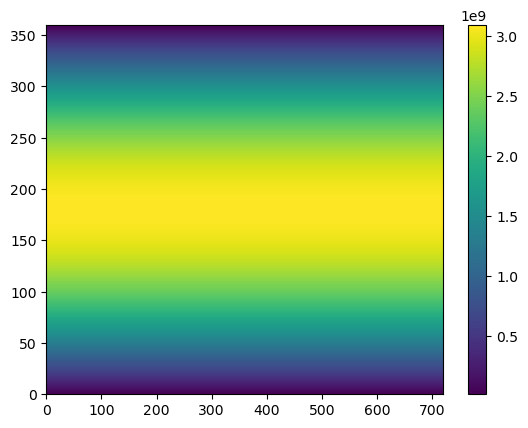

In [9]:
# make a plot of the Area with a colorbar
c = plt.pcolormesh(Area)
plt.colorbar(c)

As expected, the area is greater at the equator than the poles. Ok, now onto the trends:

### Sea Ice Area in the Northern Hemisphere
Equipped with our area function, we are now ready to compute the total sea ice area in the northern hemisphere through time. Let's make a list of files first, and then loop through them to compute the area:

In [13]:
# make a list to contain the file names
file_list = []

# loop through the 12 months
for year in range(1992,2018):
    for month in range(1,13):
        file_list.append('SIarea_'+str(year)+'_'+'{:02d}'.format(month)+'.nc')

# print out the file names (if desired)
# print(file_list)

Now, loop through each file in the list, storing the total area of the sea ice in an array for plotting:

In [14]:
# make a list to store the sea ice values
si_area = np.zeros((len(file_list),))

# loop through each file
for i in range(len(file_list)):
    
    # identify path to the data file
    month_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SIarea',file_list[i])
    
    # read in the data 
    ds = xr.open_dataset(month_file)
    SIarea = np.array(ds['SIarea'][:])
    ds.close()

    # subset to first timestep
    SIarea = SIarea[0,:,:]

    # mask points in the southern ocean
    SIarea[:180,:] = 0

    # compute the total sea ice area
    total_sea_ice_area = np.sum(SIarea*Area)

    # add the computed area to the list of sea ice values
    si_area[i] = total_sea_ice_area
    

Now that we've got our sea ice area timeseries, let's make a plot:

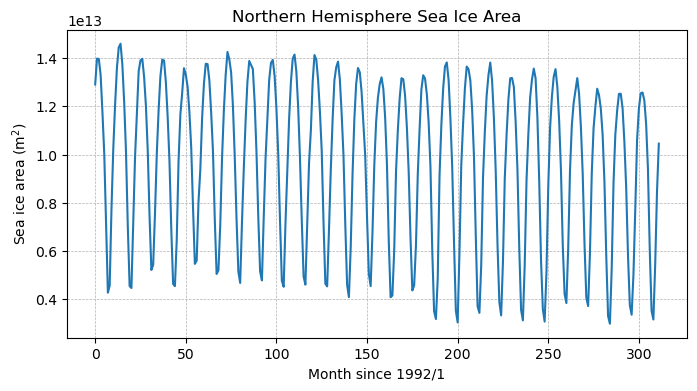

In [15]:
# make a plot of the sea ice timeseries
fig = plt.figure(figsize=(8,4))
plt.plot(si_area)
plt.title('Northern Hemisphere Sea Ice Area')
plt.ylabel('Sea ice area (m$^2$)')
plt.xlabel('Month since 1992/1')
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

### Computing Trends
How much has sea ice declined in the time period shown above? Let's compute a trend line to determine how much ice is lost during this time period.

First things first, we need to define a time array.

In [16]:
# define a time array for months
months = np.arange(len(si_area))

# convert to "decimal years"
dec_yr = 1992 + months/12

With the time array in hand, we can now fit a line to the data. To fit a simple trend line, we can use the `polyfit` function from `numpy` with a degree of 1:

In [18]:
# compute the line coefficients
p = np.polyfit(dec_yr, si_area, 1)

# print the coefficients
print(p)

# sanity check: one is the slope and one is intercept - which is which?
slope = p[0]
intercept = p[1]

[-7.11897578e+10  1.52390956e+14]


Let's plot the trend line on the data to ensure it looks as expected:

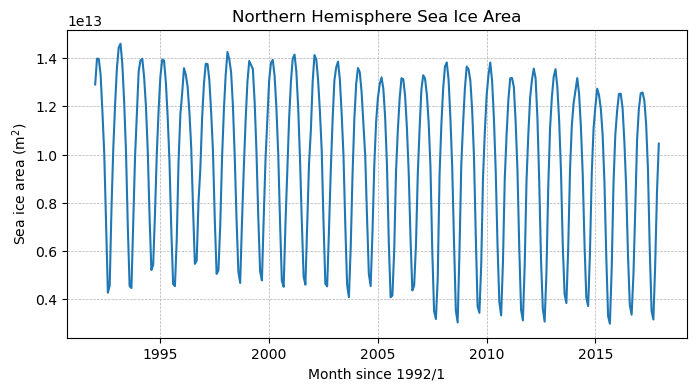

In [20]:
fig = plt.figure(figsize=(8,4))

# plot the data
plt.plot(dec_yr, si_area)

# plot the trend line
plt.plot()

plt.title('Northern Hemisphere Sea Ice Area')
plt.ylabel('Sea ice area (m$^2$)')
plt.xlabel('Month since 1992/1')
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

### Interpreting Trends
The slope of the trend line estimates how much the variable is changing through time. Consider the following questions:
1. Is northern hemisphere sea ice being lost or gained?
2. What are the units of the slope of the trend line?
3. What is the equivalent slope in units of square miles? ($1$ mile$^2$ = $2.59 \times 10^6$ m$^2$)

In [22]:
# compute the trend in square miles
slope_square_miles = slope/(2.59e6)

# print out the result
slope_square_miles

#CA square miles
CA_square_miles = 160000

print(slope_square_miles/CA_square_miles)

-0.17178995600669364


### &#x1F914; Try it yourself
How do the trends in the Southern Hemisphere compare to those in the Northern Hemisphere?

In [ ]:
# repeat your code here, but for the southern hemisphere
